In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_json('dados/ecommerce-events.ndjson', lines=True)

In [3]:
df.head()

,browserType,browserVersion,category,date,deviceType,eventType,order,orderItems,osType,osVersion,...,referrer,referrerType,searchItems,status,tags,url,utm_campaign,utm_medium,utm_source,visitor
0,Firefox,52.0.0,271|697,2017-06-03 00:07:04,desktop,page,NaN,NaN,Windows,None,...,5af64abc7cb3e5a8be6d22c97331b9afcaad91c5,social,NaN,NaN,NaN,ccde1b63b365cad611f2d1a6fca8a15b0e71d6ef,Campaign_2,Medium_2,Partner_1,89206c00-3f26-11e7-9978-fdec7f5865bc
1,Other,0.0.0,None,2017-06-03 00:07:06,desktop,page,NaN,NaN,Other,None,...,None,direct,NaN,NaN,NaN,5c808dff012fcbe74dc2941a7664e357db367176,None,None,None,b96acfe0-4809-11e7-9b7d-e57b4710e964
2,Chrome Mobile,58.0.3029,None,2017-06-03 00:07:07,mobile,page,NaN,NaN,Android,5.1.1,...,2282902993188bb2b91ce4e931c6f7a4a946f725,None,NaN,NaN,NaN,db2c1fd6668d7432a3e298b40f7b8758cc3e8447,None,None,None,70b09b50-4808-11e7-b949-31f33cf8565d
3,Chrome,50.0.2661,594|541|319,2017-06-03 00:07:24,desktop,page,NaN,NaN,Windows,7,...,e4684c143dfb4f377940afd7a228795b805e554e,None,NaN,NaN,NaN,aefa097f4f0deba18e6db60790704941b559034d,None,None,None,ff14b670-4776-11e7-8c72-5f5d3fe5c610
4,Chrome,55.0.2883,558|648,2017-06-03 00:07:38,desktop,page,NaN,NaN,Windows,None,...,3385b88a74f4bc41a423e47a8b34e188ba8c3ea8,None,NaN,NaN,NaN,131365d819084be07328b1cf624c1214c8e5faeb,None,None,None,fad427f0-d767-11e6-aea4-61a60e8da6e5


# 1. What was the total revenue?

The total revenue is 212022.27000000002

In [4]:
transactions = df[df.eventType=='transaction']

In [5]:
df_items = []
items = transactions.orderItems
for item in items:
    for i in item:
        df_items.append(i)

In [6]:
df_items = pd.DataFrame(df_items)
df_items['total'] = df_items.price * df_items.quantity

In [7]:
total_revenue = df_items.total.sum()

In [8]:
total_revenue

212022.27000000002

# 2. What percentage of visitors used a mobile device?

Approximately 41% of visitors used mobile device

In [9]:
perc = (len(df[df.deviceType == 'mobile']) / len(df)) * 100

In [10]:
perc

41.52242235082472

# 3. What search query had the highest click-through rate?


In [11]:
df_product = df[df.eventType=='product']
df_search = df[df.eventType=='search']
df_search = df_search[pd.notnull(df_search.searchItems)]

In [12]:
visitors_list = df_product.visitor.tolist()
in_visitors_list = df_search.visitor.isin(visitors_list)
df_search = df_search[in_visitors_list]

In [13]:
visitors_list = df_search.visitor.tolist()
in_visitors_list = df_product.visitor.isin(visitors_list)
df_product = df_product[in_visitors_list]

In [14]:
has_min_instances = []
search_items = df_search.searchItems
for items in search_items:
    if len(items) < 15:
        has_min_instances.append(False)
    else:
        has_min_instances.append(True)
df_search = df_search[has_min_instances]

In [15]:
is_in_product_page = []
search_items = df_search['searchItems']
products = df_product['product']
for items in search_items:
    x = False
    for item in items:
        if item in products.unique():
            x = True
    is_in_product_page.append(x)
    
df_search = df_search[is_in_product_page]

In [16]:
clicks = []
for j,vl in df_search.visitor.items():
    click = 0
    prods = df_search.loc[j, 'searchItems']
    for i,v in df_product.visitor.items():
        if v==vl:
            produ = df_product.loc[i, 'product']
            for prod in prods:
                if produ == prod:
                    click += 1
    clicks.append(click)
df_search['clicks'] = clicks

In [17]:
query_clicks = df_search.groupby('query').clicks.sum().sort_values(ascending=False)
query_clicks = pd.DataFrame(query_clicks)
query_clicks = query_clicks[query_clicks.clicks > 250]

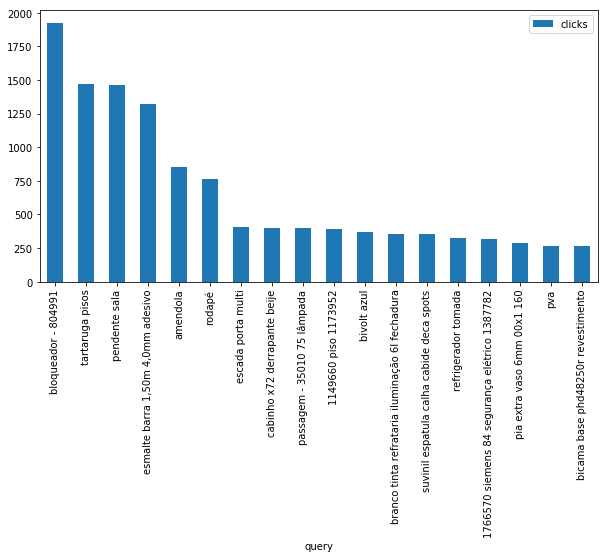

In [18]:
query_clicks.plot(kind='bar', figsize=(10,5))

# 4. When is the site most busy?

The site is most busy between 11 a.m. and 10 p.m at the beginning of the week.

In [19]:
time = df.date.apply(lambda x: x.time())

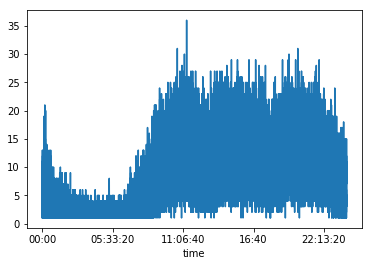

In [20]:
time.value_counts().plot()

In [21]:
nu_weekday = df.date.apply(lambda x: x.weekday())

In [22]:
weekdays = []
for n in nu_weekday:
    if n==0:
        weekday = 'monday'
    if n==1:
        weekday = 'tuesday'
    if n==2:
        weekday = 'wednesday'
    if n==3:
        weekday = 'thursday'
    if n==4:
        weekday = 'friday'
    if n==5:
        weekday = 'saturday'
    if n==6:
        weekday = 'sunday'
    weekdays.append(weekday)

In [23]:
df['weekday'] = weekdays

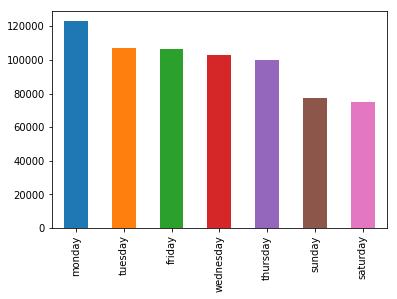

In [24]:
df.weekday.value_counts().plot(kind='bar')

# 5. What is the share of revenue among categories brought by Campaign_2?

In [25]:
df_product = df[df.eventType == 'product']
df_product = df_product[df_product.utm_campaign == 'Campaign_2']
df_transaction = df[df.eventType == 'transaction']


In [26]:
len(df_product)

10514

In [27]:
len(df_transaction)

554

In [28]:
visitors_list = df_product.visitor.tolist()
in_visitors_list = df_transaction.visitor.isin(visitors_list)
df_transaction = df_transaction[in_visitors_list]
len(df_transaction)

113

In [29]:
visitors_list = df_transaction.visitor.tolist()
in_visitors_list = df_product.visitor.isin(visitors_list)
df_product = df_product[in_visitors_list]
len(df_product)

224

In [30]:
df_items = []
items = df_transaction.orderItems
for item in items:
    for i in item:
        df_items.append(i)
df_items = pd.DataFrame(df_items)
len(df_items)

187

In [31]:
products_list = df_product['product'].tolist()
in_products_list = df_items['product'].isin(products_list)
df_items = df_items[in_products_list]
len(df_items)

82

In [32]:
total = (df_items.price * df_items.quantity).tolist()

In [33]:
df_items['total'] = total


In [34]:
categories = []
for product in df_items['product']:
    category = ''
    for i,v in df_product['product'].items():
        if product==v:
            category = df_product.loc[i, 'category']
            break
    categories.append(category)

In [35]:
df_items['category'] = categories

In [36]:
categories = df_items.groupby(['category']).total.sum()

In [37]:
categories = pd.DataFrame(categories)

In [38]:
categories['perc'] = categories.total / categories.total.sum() * 100

In [39]:
categories = categories.perc.sort_values(ascending=False)

In [40]:
categories

category
271|697        33.538351
322|173|759    14.494617
756|763|181    13.220530
271|300         9.650986
319|689|244     6.261367
349|215|628     3.765483
26|427          2.789246
29|153          2.554544
234|676|635     2.263427
558|552         1.788927
756|268|188     1.742703
319|91          1.417311
271|524         1.207177
319             1.000440
349|215         0.872989
234|725         0.772897
299|86          0.606015
26|156|109      0.496277
319|427|686     0.453146
594|439|654     0.363366
53|329|681      0.217777
319|764|6       0.185080
349|250|396     0.157115
234|115         0.126177
26|156|521      0.054050
Name: perc, dtype: float64

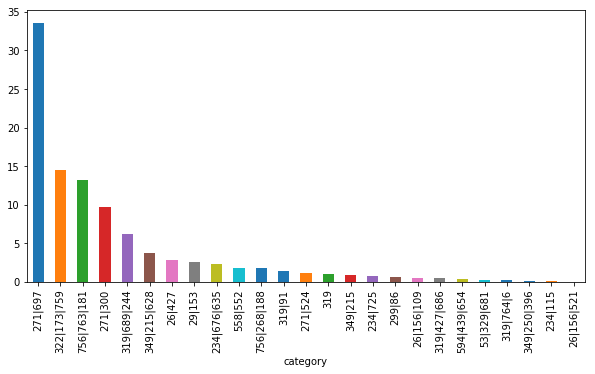

In [41]:
categories.plot(kind='bar', figsize=(10,5))

# 6. Estimate the impact of unavailable products

Approximately 20% searches resulted in more than 30% of unavailable products


Approximately 9,5% searches resulted in more than 60% of unavailable products

In [42]:
df_product = df[df.eventType == 'product']
df_product = df_product[df_product.status == 'UNAVAILABLE']

In [43]:
df_search = df[df.eventType == 'search']
df_search = df_search[pd.notnull(df_search.searchItems)]

In [44]:
search_items = df_search.searchItems
unavailable_products = df_product['product'].tolist()

In [45]:
qtd_un = []
qtd_products = []
for items in search_items:
    un = 0
    for item in items:
        if item in unavailable_products:
            un += 1
    qtd_products.append(len(items))
    qtd_un.append(un)

In [46]:
df_search['qtd_unavailables'] = qtd_un
df_search['qtd_products'] = qtd_products
df_search['perc_unavailables'] = df_search.qtd_unavailables / df_search.qtd_products * 100

In [47]:
len(df_search[df_search.perc_unavailables > 30]) / len(df_search) * 100

19.868916130598375

In [48]:
len(df_search[df_search.perc_unavailables > 60]) / len(df_search) * 100

9.538258803946388